In [1]:
%reset-f


In [30]:
%load_ext autoreload
%autoreload
from wb_api_wraper import *
from scat import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Income of each quitinile in 2005 USD PPP

In [3]:
share1   =get_wb_mrv('SI.DST.FRST.20'   ,"share1")/100#share of income bottom 20%
share2   =get_wb_mrv('SI.DST.02nd.20'   ,"share2")/100#share of income second 
share3   =get_wb_mrv('SI.DST.03rd.20'   ,"share3")/100#share of income 3rd
share4   =get_wb_mrv('SI.DST.04th.20'   ,"share4")/100#share of income 4th
share5   =get_wb_mrv('SI.DST.05th.20'   ,"share5")/100#share of income 5th

In [4]:
gdp_pc_pp=get_wb_mrv('NY.GDP.PCAP.pp.kd',"gdp_pc_pp")/ 1.152 #Gdp per capita from 2011PPP to 2005 PPP
gdp_tot_pp=get_wb_mrv('NY.GDP.MKTP.PP.KD',"gdp_tot_pp")/ 1.152 #Gdp from 2011PPP to 2005 PPP


In [5]:
y1=share1*gdp_pc_pp*5
y2=share2*gdp_pc_pp*5
y3=share3*gdp_pc_pp*5
y4=share4*gdp_pc_pp*5
y5=share5*gdp_pc_pp*5


income=pd.DataFrame()
income["poor"]=y1
income["nonpoor"]=(y2+y3+y4+y5)
income["pop"]=gdp_pc_pp
income["extreme"]=1.25 * 365


Size of each income group

In [31]:
group_size=pd.DataFrame()
group_size["poor"]=.20
group_size["nonpoor"]=.80
group_size["pop"]=1
group_size["extreme"]=np.nan

Gets list of all aspire indicators

In [6]:
#Get all wb indicators 
a=wb.search(".*")
a.to_csv("wb_indicators_library.csv")
all_aspire_indicators = a.ix[["ASPIRE" in s.decode("utf-8") for s in a.sourceOrganization.tolist()]] #ASPIRE cited in source
all_aspire_indicators.to_csv("hop.csv")

In [7]:
what_to_code = pd.read_csv("aspire_what_codes.csv",index_col=0,squeeze=True) #disct from Mook
what_to_code
list_what_names=  what_to_code.index.tolist()
what_to_code

desc
Coverage               cov
Adequacy               adq
Per Capita Transfer    avt
Name: code, dtype: object

In [8]:
cat_to_code = pd.read_csv("aspire_cat_codes.csv",index_col=0,squeeze=True) #disct from Mook
cat_to_code

Description
Active Labor Market                   _lm_ac
All Labor Market                   _lm_alllm
All Private Transfers                   _rem
All Social Assistance              _sa_allsa
All Social Insurance               _si_allsi
Cash Transfer                         _sa_ct
Conditional Cash Transfers           _sa_cct
Contributory Pensions                 _si_oa
Domestic Private Transfers            _pr_dp
In-Kind                               _sa_ik
International Private Transfers       _pr_ip
Other Social Assistance              _sa_osa
Other Social Insurance                _si_ss
Passive Labor Market                  _lm_ub
Public Works                          _sa_pw
School Feeding                        _sa_sf
Social Pensions                       _sa_sp
Subsidies                             _sa_su
All Social Protection and Labor       _allsp
Name: Middle Code, dtype: object

In [9]:
list_cat_names =  ["All Labor Market" ,"All Social Assistance" ,"All Social Insurance" ,"All Private Transfers"]
#convinience
alm,asa,asi,apt = list_cat_names
list_cat_codes = [cat_to_code[desc] for desc in list_cat_names ]
list_cat_codes

['_lm_alllm', '_sa_allsa', '_si_allsi', '_rem']

In [10]:
income_group_to_keys = pd.read_csv("income_groups.csv",index_col=0,squeeze=True)
list_income_groups = income_group_to_keys.index.tolist()
income_group_to_keys

group
poor                      ["q1"]
nonpoor    ["q2","q3","q4","q5"]
pop                      ["pop"]
extreme                   ["ep"]
Name: keys, dtype: object

###share of income from various type of transfers

In [13]:
#todo: get the querry out of the loop

In [14]:
shares=pd.DataFrame(columns=pd.MultiIndex.from_product([list_cat_names, list_income_groups], names=['category', 'income_group']))

for cat in list_cat_names:
    cat_code   = cat_to_code[cat]

    for income_group in list_income_groups:
        #transfer of this income group
        t=0
        for income_code in eval(income_group_to_keys[income_group]):
            t+=mrv(get_wb_series("per"+cat_code+"."+"avt_"+income_code+"_tot"))
                
        shares[cat,income_group] = 100*365*t/income[income_group]#percent



In [15]:
shares=shares.dropna()  
shares["gdp"]=gdp_tot_pp
shares["gdp_pc"]=gdp_pc_pp


In [16]:
key_to_col = pd.read_csv("cat_color.txt",index_col=0,squeeze=True)

In [40]:
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}

plt.rc('font', **font)

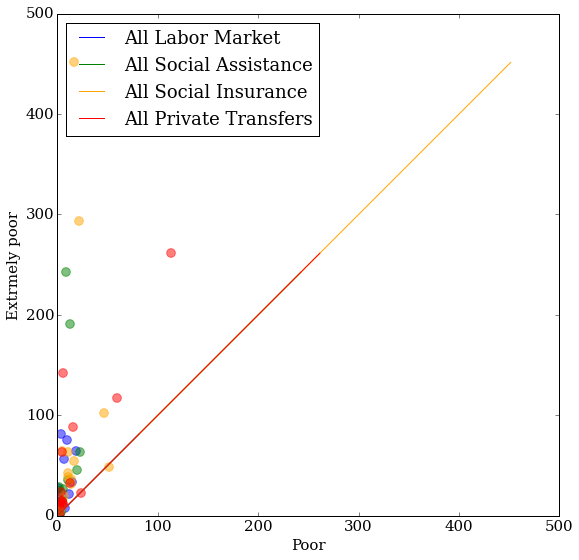

In [18]:
plt.figure(figsize=(9,9))
for cat in list_cat_names:
    plt.scatter(shares[cat,"poor"],shares[cat,"extreme"],color=key_to_col[cat],alpha=.5,s=75)
    plt.xlabel("Poor")
    plt.ylabel("Extrmely poor")
    m=max(shares[cat,"poor"].max(),shares[cat,"extreme"].max())
    plt.plot([0, m],[0,m],color=key_to_col[cat])
    
plt.legend(list_cat_names,loc="upper left")    
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.savefig("share_of_income_from_transferts_ep.png")

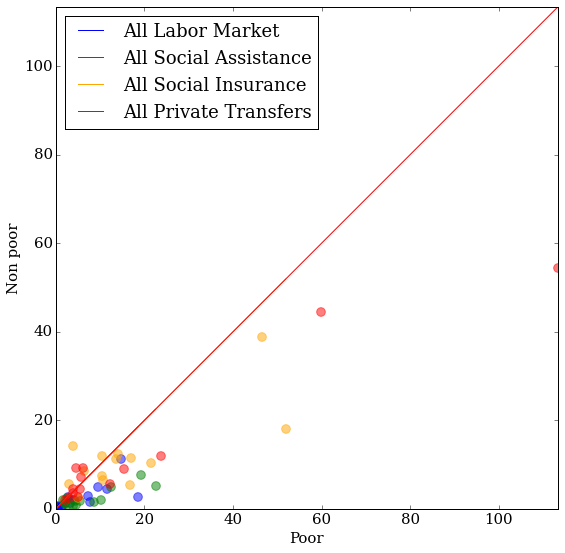

In [50]:
plt.figure(figsize=(9,9))
for cat in list_cat_names:
    plt.scatter(shares[cat,"poor"],shares[cat,"nonpoor"],color=key_to_col[cat],alpha=.5,s=75)
    plt.xlabel("Poor")
    plt.ylabel("Non poor")
    m=max(shares[cat,"poor"].max(),shares[cat,"nonpoor"].max())
    plt.plot([0, m],[0,m],color=key_to_col[cat])
    
plt.legend(list_cat_names,loc="upper left")    
plt.xlim(xmin=0,xmax=m)
plt.ylim(ymin=0,ymax=m)
plt.savefig("share_of_income_from_transferts.png")

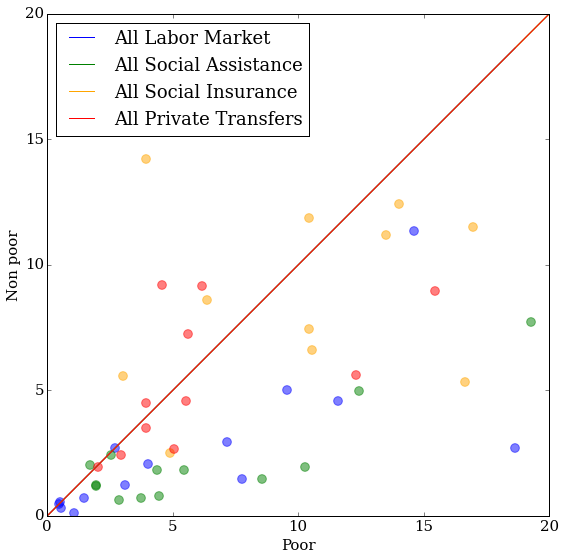

In [20]:
plt.figure(figsize=(9,9))
for cat in list_cat_names:
    plt.scatter(shares[cat,"poor"],shares[cat,"nonpoor"],color=key_to_col[cat],alpha=.5,s=75)
    plt.xlabel("Poor")
    plt.ylabel("Non poor")
    m=max(shares[cat,"poor"].max(),shares[cat,"nonpoor"].max())
    plt.plot([0, m],[0,m],color=key_to_col[cat])
    
plt.legend(list_cat_names,loc="best")    
plt.xlim(xmin=0,xmax=20)
plt.ylim(ymin=0,ymax=20)
plt.savefig("share_of_income_from_transferts_zoom.png")


Coverage

In [37]:
coverages=pd.DataFrame(columns=pd.MultiIndex.from_product([list_cat_names, list_income_groups], names=['category', 'income_group']))

for cat in list_cat_names:
    cat_code   = cat_to_code[cat]

    for income_group in list_income_groups:
        #transfer of this income group
        covered=0
        income_keys = eval(income_group_to_keys[income_group])
        ell = len(income_keys)
        for income_code in income_keys:
            covered+=mrv(get_wb_series("per"+cat_code+"."+"cov_"+income_code+"_tot"))/ell
                
        coverages[cat,income_group] = covered


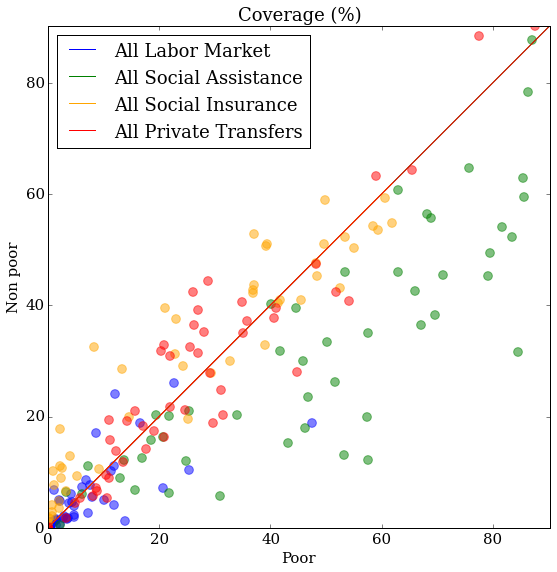

In [51]:
plt.figure(figsize=(9,9))
for cat in list_cat_names:
    plt.scatter(coverages[cat,"poor"],coverages[cat,"nonpoor"],color=key_to_col[cat],alpha=.5,s=75)
    plt.xlabel("Poor")
    plt.ylabel("Non poor")
    m=max(coverages[cat,"poor"].max(),coverages[cat,"nonpoor"].max())
    plt.plot([0, m],[0,m],color=key_to_col[cat])
    
plt.legend(list_cat_names,loc="upper left")    
plt.xlim(xmin=0,xmax=m)
plt.ylim(ymin=0,ymax=m)
plt.title("Coverage (%)")
plt.savefig("coverages.png")

In [62]:
dollars=pd.DataFrame(columns=pd.MultiIndex.from_product([list_cat_names, list_income_groups], names=['category', 'income_group']))

for cat in list_cat_names:
    cat_code   = cat_to_code[cat]

    for income_group in list_income_groups:
        #transfer of this income group
        dol=0
        income_keys = eval(income_group_to_keys[income_group])
        ell = len(income_keys)
        for income_code in income_keys:
            dol+=mrv(get_wb_series("per"+cat_code+"."+"avt_"+income_code+"_tot"))*mrv(get_wb_series("per"+cat_code+"."+"cov_"+income_code+"_tot"))/ell
                
        dollars[cat,income_group] = dol*365


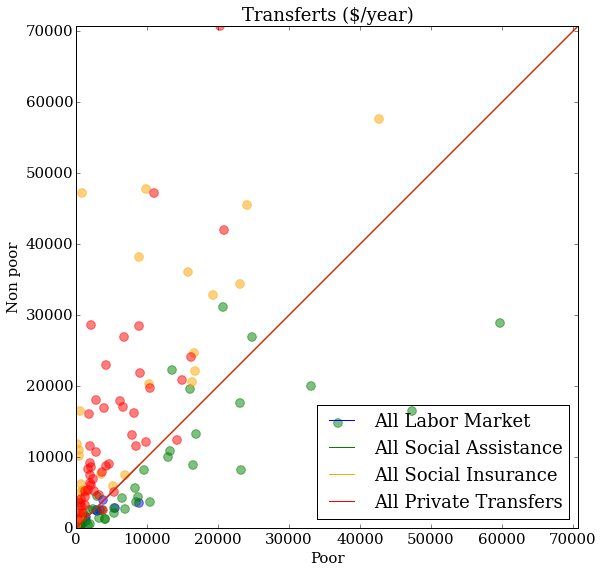

In [63]:
plt.figure(figsize=(9,9))
for cat in list_cat_names:
    plt.scatter(dollars[cat,"poor"],dollars[cat,"nonpoor"],color=key_to_col[cat],alpha=.5,s=75)
    plt.xlabel("Poor")
    plt.ylabel("Non poor")
    m=max(dollars[cat,"poor"].max(),dollars[cat,"nonpoor"].max())
    plt.plot([0, m],[0,m],color=key_to_col[cat])
    
plt.legend(list_cat_names,loc="lower right")    
plt.xlim(xmin=0,xmax=m)
plt.ylim(ymin=0,ymax=m)
plt.title("Transferts ($/year)")
plt.savefig("dollars.png")

In [64]:
plt.figure(figsize=(9,9))
plt.scatter(dollars["poor"].sum(),dollars["nonpoor"].sum(),color=key_to_col[cat],alpha=.5,s=75)
plt.xlabel("Poor")
plt.ylabel("Non poor")
m=max(dollars["poor"].sum().max(),dollars["nonpoor"].sum().max())
plt.plot([0, m],[0,m],color=key_to_col[cat])
    
plt.legend(list_cat_names,loc="lower right")    
plt.xlim(xmin=0,xmax=m)
plt.ylim(ymin=0,ymax=m)
plt.title("Transferts ($/year)")
plt.savefig("dollars-total.png")

KeyError: 'poor'

In [69]:
dollars.xs("poor",level="income_group",axis=1)

category,All Labor Market,All Social Assistance,All Social Insurance,All Private Transfers
country,,,,
Albania,149.627247,2981.070042,19331.155041,4557.847814
Argentina,532.245234,6920.114942,21525.520112,6211.837941
Armenia,244.351124,5292.642590,16605.138319,8470.813565
Azerbaijan,296.425813,63202.787550,16801.926360,2028.244233
Bangladesh,129.661305,531.136053,11.792298,1285.331365
Belarus,115.145722,33031.826205,73149.363663,20865.152428
Belize,NaN,423.382943,6919.234032,14147.839107
Bosnia and Herzegovina,639.789588,13462.857689,24047.161613,10426.497307
Brazil,NaN,8690.269447,5358.721814,896.916303
